In [2]:
import pandas as pd
import numpy as np
from typing import Optional, Tuple

df = pd.read_excel("/kaggle/input/full-dataset/FINISHED_MasterSheet (1).xlsx")

In [3]:
def _split_to_numbers(cell, cast):
    if pd.isna(cell):
        return []
    parts = [p.strip() for p in str(cell).split(",") if p.strip()]
    out = []
    for p in parts:
        try:
            out.append(cast(p))
        except Exception:
            pass
    return out

In [4]:
def pick_closest_defender(ids_cell, xs_cell, ys_cell) -> Optional[Tuple[int, float]]:
    ids = _split_to_numbers(ids_cell, int)
    xs = _split_to_numbers(xs_cell, float)
    ys = _split_to_numbers(ys_cell, float)

    if len(ids) < 2 or len(xs) != len(ids) or len(ys) != len(ids):
        return None

    tgt_x, tgt_y = xs[-1], ys[-1]
    def_ids = ids[:-1]
    def_xs = xs[:-1]
    def_ys = ys[:-1]
    if not def_ids:
        return None

    dists = [np.hypot(dx - tgt_x, dy - tgt_y) for dx, dy in zip(def_xs, def_ys)]
    idx = int(np.argmin(dists))
    return int(def_ids[idx]), float(dists[idx])


In [5]:
df_filt = df.loc[df["player_to_predict"] == True].copy()

In [6]:
def process_play(g: pd.DataFrame) -> pd.DataFrame:
    valid = g.dropna(subset=["Concat_Right_nfl_id", "Concat_Right_x", "Concat_Right_y"])
    if valid.empty:
        return g.iloc[0:0]

    row = valid.iloc[0]
    result = pick_closest_defender(
        row["Concat_Right_nfl_id"],
        row["Concat_Right_x"],
        row["Concat_Right_y"],
    )
    if result is None:
        return g.iloc[0:0]

    chosen_def_id, _ = result
    kept = g.loc[g["nfl_id"] == chosen_def_id].copy()
    kept["coverage_defender_id"] = chosen_def_id
    return kept

In [7]:
coverage_df = (
    df_filt
    .groupby(["game_id", "play_id"], group_keys=False)
    .apply(process_play)
    .reset_index(drop=True)
)

print("Rows kept:", len(coverage_df))
print("Unique plays covered:", coverage_df[["game_id", "play_id"]].drop_duplicates().shape[0])
print("Unique coverage defenders:", coverage_df["coverage_defender_id"].nunique())

/tmp/ipykernel_38/575630709.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_play)


Rows kept: 151180
Unique plays covered: 12966
Unique coverage defenders: 617


In [8]:
def parse_clock_to_seconds(cell):
    if pd.isna(cell):
        return np.nan
    s = str(cell).strip()
    if ":" not in s:
        return np.nan
    mm, ss = s.split(":", 1)
    try:
        return int(mm) * 60 + int(ss)
    except Exception:
        return np.nan


In [9]:
base = coverage_df if "coverage_df" in globals() else df

work = base.copy()
work["quarter_num"] = pd.to_numeric(work["quarter"], errors="coerce")
work["seconds_remaining"] = work["game_clock"].map(parse_clock_to_seconds)

sorted_df = (
    work.sort_values(
        by=["game_id", "quarter_num", "seconds_remaining"],
        ascending=[True, True, False],
        kind="mergesort",
    )
    .drop(columns=["quarter_num", "seconds_remaining"])
    .reset_index(drop=True)
)

print(f"sorted_df ready (rows: {len(sorted_df)})")


sorted_df ready (rows: 151180)


In [10]:
_POS_HEIGHT_IN = {
    "CB": 72.0, "FS": 73.0, "SS": 73.0, "S": 73.0,
    "ILB": 74.0, "MLB": 74.0, "OLB": 75.0, "DE": 77.0,
    "WR": 73.0, "TE": 77.0, "RB": 70.0, "QB": 75.0, "FB": 72.0,
}

_POS_WS_HT_RATIO = {
    "CB": 1.02, "FS": 1.02, "SS": 1.02, "S": 1.02,
    "ILB": 1.02, "MLB": 1.02, "OLB": 1.02, "DE": 1.02,
    "WR": 1.03, "TE": 1.04, "RB": 1.02, "QB": 1.02, "FB": 1.02,
}

_POS_VERTICAL_IN = {
    "CB": 37.0, "FS": 36.0, "SS": 36.0, "S": 36.0,
    "ILB": 33.0, "MLB": 33.0, "OLB": 33.0, "DE": 33.0,
    "WR": 36.0, "TE": 33.0, "RB": 35.0, "QB": 31.0, "FB": 31.0,
}

_OVERALL_HEIGHT_IN = 72.7
_OVERALL_WS_HT_RATIO = 1.02
_OVERALL_VERTICAL_IN = 34.6

In [11]:
def _norm_pos(pos):
    if pd.isna(pos):
        return None
    return str(pos).upper().strip()


In [12]:
def _coalesce_first(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


In [13]:
def _parse_height_like(series: pd.Series):
    s = series.astype(str).str.strip()
    out = pd.to_numeric(s, errors="coerce")

    mask = out.isna()
    if mask.any():

        def _to_in(h: str):
            h = (
                h.lower()
                .replace('"', "")
                .replace("in", "")
                .replace("inch", "")
                .replace("ft", "'")
                .replace("’", "'")
                .replace("`", "'")
                .replace(" ", "")
            )
            if "'" in h:
                parts = h.split("'")
                try:
                    ft = int(parts[0]) if parts[0] else 0
                    ins = int(parts[1]) if len(parts) > 1 and parts[1] else 0
                    return ft * 12 + ins
                except Exception:
                    return np.nan
            if "-" in h:
                parts = h.split("-")
                try:
                    ft = int(parts[0]) if parts[0] else 0
                    ins = int(parts[1]) if len(parts) > 1 and parts[1] else 0
                    return ft * 12 + ins
                except Exception:
                    return np.nan
            return np.nan

        out.loc[mask] = s.loc[mask].map(_to_in)

    return pd.to_numeric(out, errors="coerce")


In [14]:
def add_catch_radius_columns(df: pd.DataFrame, pos_col: str = "player_position") -> pd.DataFrame:
    out = df.copy()

    if pos_col in out.columns:
        pos_norm = out[pos_col].map(_norm_pos)
    else:
        pos_norm = pd.Series([None] * len(out), index=out.index)

    height_col = _coalesce_first(out, ["height_in", "player_height_in", "height", "player_height"])
    if height_col is not None:
        height_in = _parse_height_like(out[height_col])
    else:
        height_in = pos_norm.map(lambda p: _POS_HEIGHT_IN.get(p, _OVERALL_HEIGHT_IN))
    out["height_in"] = pd.to_numeric(height_in, errors="coerce")

    wingspan_col = _coalesce_first(out, ["wingspan_in", "armspan_in", "wingspan"])
    if wingspan_col is not None:
        out["wingspan_est_in"] = pd.to_numeric(out[wingspan_col], errors="coerce")
    else:
        ratio = pos_norm.map(lambda p: _POS_WS_HT_RATIO.get(p, _OVERALL_WS_HT_RATIO))
        out["wingspan_est_in"] = out["height_in"] * ratio

    vertical_col = _coalesce_first(out, ["vertical_in", "vertical_leap_in", "vertical"])
    if vertical_col is not None:
        out["vertical_est_in"] = pd.to_numeric(out[vertical_col], errors="coerce")
    else:
        out["vertical_est_in"] = pos_norm.map(lambda p: _POS_VERTICAL_IN.get(p, _OVERALL_VERTICAL_IN))

    ws_half = out["wingspan_est_in"] / 2.0
    vert = out["vertical_est_in"]
    out["catch_radius_in"] = np.sqrt(ws_half**2 + vert**2)
    out["catch_radius_ft"] = out["catch_radius_in"] / 12.0

    return out


In [15]:
sorted_df = add_catch_radius_columns(sorted_df)

In [16]:
def recompute_num_frames_output(df: pd.DataFrame) -> pd.DataFrame:
    group_keys = ["game_id", "play_id"]
    if "coverage_defender_id" in df.columns:
        group_keys.append("coverage_defender_id")

    out = df.copy()
    counts = out.groupby(group_keys).size()
    aligned = counts.reindex(out.set_index(group_keys).index, method="ffill")
    out["num_frames_output"] = aligned.to_numpy().astype(int)
    return out


In [17]:
sorted_df = recompute_num_frames_output(sorted_df)

In [18]:
SECONDS_PER_FRAME = 0.1

def _short_angle_diff(a_deg, b_deg):
    a = np.asarray(a_deg, dtype=float)
    b = np.asarray(b_deg, dtype=float)
    diff = np.abs((a - b) % 360.0)
    return np.where(diff > 180.0, 360.0 - diff, diff)


In [19]:
def _bin_pass_length(pl):
    if pd.isna(pl):
        return "UNKNOWN"
    try:
        v = float(pl)
    except Exception:
        return "UNKNOWN"

    if v < 0:
        return "<0"
    if v < 10:
        return "0-9.99"
    if v < 20:
        return "10-19.99"
    if v < 30:
        return "20-29.99"
    if v < 40:
        return "30-39.99"
    if v < 50:
        return "40-49.99"
    return "50+"


In [20]:
def compute_patience_per_play(
    sorted_df: pd.DataFrame,
    orientation_improve_thresh: float = 3.0,
    penalty_lambda: float = 0.25,
    min_similar_plays: int = 5,
) -> pd.DataFrame:
    required = [
        "game_id", "play_id", "frame_id", "coverage_defender_id",
        "x", "y", "dir",
        "ball_land_x", "ball_land_y",
        "team_coverage_man_zone",
    ]
    for c in required:
        if c not in sorted_df.columns:
            raise KeyError(f"Missing column '{c}' in sorted_df.")

    if ("catch_radius_yards" not in sorted_df.columns) and ("catch_radius_ft" not in sorted_df.columns):
        raise KeyError("Need 'catch_radius_yards' or 'catch_radius_ft' in sorted_df.")

    work = sorted_df.copy()

    cov = work["team_coverage_man_zone"].astype(str)
    prefix = cov.str.split("_").str[0].str.upper()
    work["coverage_family"] = np.where(prefix == "MAN", "MAN", "ZONE")

    if "pass_length" not in work.columns:
        work["pass_length"] = np.nan
    work["pass_length_bin"] = work["pass_length"].map(_bin_pass_length)

    if "catch_radius_yards" in work.columns:
        work["catch_radius_yd"] = pd.to_numeric(work["catch_radius_yards"], errors="coerce")
    else:
        work["catch_radius_yd"] = pd.to_numeric(work["catch_radius_ft"], errors="coerce") / 3.0

    records = []
    group_keys = ["game_id", "play_id", "coverage_defender_id"]

    for (gid, pid, cov_id), g in work.groupby(group_keys, sort=False):
        g = g.copy()
        if g.empty:
            continue

        g = g.sort_values("frame_id", kind="mergesort").reset_index(drop=True)
        g["_t"] = np.arange(len(g), dtype=int)

        player_name = g["player_name"].iloc[0] if "player_name" in g.columns else np.nan
        player_pos = g["player_position"].iloc[0] if "player_position" in g.columns else np.nan
        coverage_family = g["coverage_family"].iloc[0]
        team_cov_type = g["team_coverage_man_zone"].iloc[0]
        pass_len = pd.to_numeric(g["pass_length"].iloc[0], errors="coerce") if "pass_length" in g.columns else np.nan
        pass_bin = g["pass_length_bin"].iloc[0]

        bx = pd.to_numeric(g["ball_land_x"].iloc[0], errors="coerce")
        by = pd.to_numeric(g["ball_land_y"].iloc[0], errors="coerce")
        cr = pd.to_numeric(g["catch_radius_yd"].iloc[0], errors="coerce")

        if np.isnan(bx) or np.isnan(by) or np.isnan(cr):
            continue

        xs = pd.to_numeric(g["x"], errors="coerce")
        ys = pd.to_numeric(g["y"], errors="coerce")
        dirs = pd.to_numeric(g["dir"], errors="coerce")

        dists = np.hypot(xs - bx, ys - by)

        dx = bx - xs
        dy = by - ys
        ball_angle = np.degrees(np.arctan2(dy, dx))
        ball_angle = np.where(ball_angle < 0, ball_angle + 360.0, ball_angle)

        orient_err = _short_angle_diff(dirs, ball_angle)

        play_frames = len(g)
        play_length_s = play_frames * SECONDS_PER_FRAME

        within_radius = (dists <= cr).values
        success_flag = bool(within_radius.any())

        if np.isnan(orient_err[0]):
            continue
        error_0 = orient_err[0]

        improve = error_0 - orient_err
        reaction_candidates = np.where(improve >= orientation_improve_thresh)[0]

        if len(reaction_candidates) == 0:
            continue

        reaction_frame = int(reaction_candidates[0])

        if success_flag:
            entry_idxs = np.where(within_radius)[0]
            entry_frame = int(entry_idxs[0])
            trigger_frame = max(reaction_frame, entry_frame)
        else:
            trigger_frame = reaction_frame

        trigger_time_raw_s = trigger_frame * SECONDS_PER_FRAME

        dist_last = float(dists.iloc[-1])
        remaining_distance = max(dist_last - cr, 0.0)

        records.append({
            "game_id": gid,
            "play_id": pid,
            "coverage_defender_id": cov_id,
            "player_name": player_name,
            "player_position": player_pos,
            "coverage_family": coverage_family,
            "team_coverage_man_zone": team_cov_type,
            "pass_length": pass_len,
            "pass_length_bin": pass_bin,
            "play_length_s": play_length_s,
            "success_flag": success_flag,
            "trigger_time_raw_s": float(trigger_time_raw_s),
            "remaining_distance": float(remaining_distance),
            "catch_radius_yd": float(cr),
        })

    play_df = pd.DataFrame(records)
    if play_df.empty:
        print("No valid plays found in compute_patience_per_play.")
        return play_df

    before_len = len(play_df)
    play_df = play_df[play_df["play_length_s"] <= 7.0].copy()
    after_len = len(play_df)
    print(f"Dropped {before_len - after_len} plays > 7s; {after_len} remain.")

    if play_df.empty:
        print("All plays were longer than 7 seconds after filtering.")
        return play_df

    success_df = play_df[play_df["success_flag"]].copy()
    baseline = (
        success_df
        .groupby(["coverage_family", "pass_length_bin"], dropna=False)
        .agg(
            baseline_trigger_s=("trigger_time_raw_s", "mean"),
            n_success=("trigger_time_raw_s", "count"),
        )
        .reset_index()
    )

    play_df = play_df.merge(
        baseline,
        on=["coverage_family", "pass_length_bin"],
        how="left",
    )

    final = play_df["trigger_time_raw_s"].copy()

    mask_fail = ~play_df["success_flag"]
    mask_has_baseline = (
        mask_fail &
        play_df["baseline_trigger_s"].notna() &
        (play_df["n_success"] >= min_similar_plays)
    )

    norm_rem = np.zeros(len(play_df), dtype=float)
    cr_safe = np.where(play_df["catch_radius_yd"] > 0, play_df["catch_radius_yd"], 1.0)
    norm_rem[mask_has_baseline] = (
        play_df.loc[mask_has_baseline, "remaining_distance"].values /
        cr_safe[mask_has_baseline]
    )

    penalty_factor = np.ones(len(play_df), dtype=float)
    penalty_factor[mask_has_baseline] = np.minimum(
        np.exp(penalty_lambda * norm_rem[mask_has_baseline]),
        3.0,
    )

    final[mask_has_baseline] = (
        play_df.loc[mask_has_baseline, "baseline_trigger_s"].values *
        penalty_factor[mask_has_baseline]
    )

    play_df["patience_time_s"] = final.astype(float)

    return play_df


In [21]:
play_df = compute_patience_per_play(sorted_df)
print(f"Built play_df with {len(play_df)} play-level rows.")


Dropped 0 plays > 7s; 8542 remain.
Built play_df with 8542 play-level rows.


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


In [22]:
from functools import reduce 

def compute_man_zone_patience_scores(
    play_df: pd.DataFrame,
    min_total_plays: int = 20,
    min_man_plays: int = 5,
    min_zone_plays: int = 5,
    col_player_name: str = "player_name",
    col_def_id: str = "coverage_defender_id",
) -> pd.DataFrame:
    work = play_df.copy()
    if work.empty:
        print("play_df is empty in compute_man_zone_patience_scores.")
        return pd.DataFrame()

    id_col = col_def_id
    name_col = col_player_name
    pos_col = "player_position" if "player_position" in work.columns else None

    base_group = [id_col, name_col] + ([pos_col] if pos_col else [])

    overall = (
        work.groupby(base_group, dropna=False)
        .agg(
            total_plays=("patience_time_s", "count"),
            avg_patience_overall_s=("patience_time_s", "mean"),
        )
        .reset_index()
    )

    man_df = work[work["coverage_family"] == "MAN"]
    man_agg = (
        man_df.groupby(base_group, dropna=False)
        .agg(
            man_plays=("patience_time_s", "count"),
            avg_patience_man_s=("patience_time_s", "mean"),
        )
        .reset_index()
    )

    zone_df = work[work["coverage_family"] == "ZONE"]
    zone_agg = (
        zone_df.groupby(base_group, dropna=False)
        .agg(
            zone_plays=("patience_time_s", "count"),
            avg_patience_zone_s=("patience_time_s", "mean"),
        )
        .reset_index()
    )

    dfs_to_merge = [overall, man_agg, zone_agg]
    player = reduce(
        lambda left, right: pd.merge(left, right, on=base_group, how="outer"),
        dfs_to_merge,
    )

    for c in ["total_plays", "man_plays", "zone_plays"]:
        if c in player.columns:
            player[c] = player[c].fillna(0).astype(int)

    man_qual = player[
        (player.get("man_plays", 0) >= min_man_plays) &
        player["avg_patience_man_s"].notna()
    ].copy()

    if not man_qual.empty:
        mean_man = float(man_qual["avg_patience_man_s"].mean())
        std_man = float(man_qual["avg_patience_man_s"].std(ddof=0))
        if np.isnan(std_man) or std_man == 0:
            std_man = 1.0
        player["patience_score_man"] = (mean_man - player["avg_patience_man_s"]) / std_man
    else:
        player["patience_score_man"] = np.nan

    zone_qual = player[
        (player.get("zone_plays", 0) >= min_zone_plays) &
        player["avg_patience_zone_s"].notna()
    ].copy()

    if not zone_qual.empty:
        mean_zone = float(zone_qual["avg_patience_zone_s"].mean())
        std_zone = float(zone_qual["avg_patience_zone_s"].std(ddof=0))
        if np.isnan(std_zone) or std_zone == 0:
            std_zone = 1.0
        player["patience_score_zone"] = (mean_zone - player["avg_patience_zone_s"]) / std_zone
    else:
        player["patience_score_zone"] = np.nan

    man_w = player.get("man_plays", pd.Series(0, index=player.index)).astype(float)
    zone_w = player.get("zone_plays", pd.Series(0, index=player.index)).astype(float)
    man_z = player["patience_score_man"].fillna(0.0)
    zone_z = player["patience_score_zone"].fillna(0.0)

    num = man_w * man_z + zone_w * zone_z
    den = man_w.where(player["patience_score_man"].notna(), 0.0) + \
          zone_w.where(player["patience_score_zone"].notna(), 0.0)

    player["patience_score"] = np.where(den > 0, num / den, np.nan)

    elig_mask = (
        (player["total_plays"] >= min_total_plays) &
        (
            (player.get("man_plays", 0) >= min_man_plays) |
            (player.get("zone_plays", 0) >= min_zone_plays)
        )
    )
    player = player[elig_mask].copy()

    player = player.sort_values("patience_score", ascending=False).reset_index(drop=True)

    print("---- PATIENCE SCORES --------------------------------------")
    print(f"Min total plays per player: {min_total_plays}")
    print(f"Min man plays per player:   {min_man_plays}")
    print(f"Min zone plays per player:  {min_zone_plays}")
    print(f"Players kept: {len(player)}")
    cols_show = [
        col_player_name, "player_position",
        "total_plays", "man_plays", "zone_plays",
        "avg_patience_overall_s", "avg_patience_man_s", "avg_patience_zone_s",
        "patience_score_man", "patience_score_zone", "patience_score",
    ]
    cols_show = [c for c in cols_show if c in player.columns]
    print(player[cols_show].head(10))
    print("-----------------------------------------------------------")

    return player


In [23]:
player_scores = compute_man_zone_patience_scores(
    play_df,
    min_total_plays=20,
    min_man_plays=5,
    min_zone_plays=5,
)

print("===== FULL PLAYER PATIENCE SCORES =====")
if not player_scores.empty:
    print(player_scores.to_string(index=False))
else:
    print("No players met the minimum play requirement.")
print("======================================")

---- PATIENCE SCORES --------------------------------------
Min total plays per player: 20
Min man plays per player:   5
Min zone plays per player:  5
Players kept: 179
         player_name player_position  total_plays  man_plays  zone_plays  \
0  Michael Carter II              CB           35         18          17   
1      Jordyn Brooks             ILB           22          3          19   
2        Tre Herndon              CB           27          5          22   
3     Michael Hoecht             OLB           24          1          23   
4     Kei'Trel Clark              CB           25          4          21   
5     Markquese Bell              SS           22          5          17   
6       Dre Greenlaw             ILB           33          2          31   
7        Jamin Davis             OLB           22          9          13   
8     David Long Jr.             ILB           26          5          21   
9     Germaine Pratt             OLB           31          5          2

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


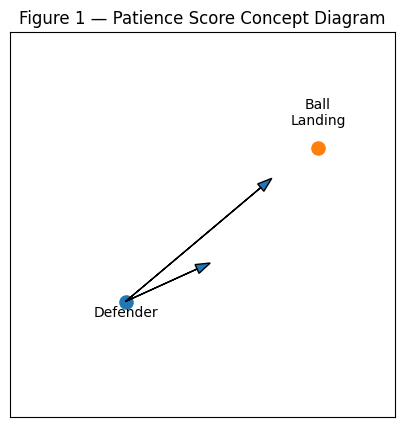

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_xlim(0, 10); ax.set_ylim(0, 10)

ax.scatter([3], [3], s=90)
ax.text(3, 2.6, "Defender", ha="center")

ax.scatter([8], [7], s=90)
ax.text(8, 7.6, "Ball\nLanding", ha="center")

ax.arrow(3, 3, 2.2, 1.0, head_width=0.25, length_includes_head=True)
ax.arrow(3, 3, 3.8, 3.2, head_width=0.25, length_includes_head=True)

ax.set_title("Figure 1 — Patience Score Concept Diagram")
ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])
plt.show()

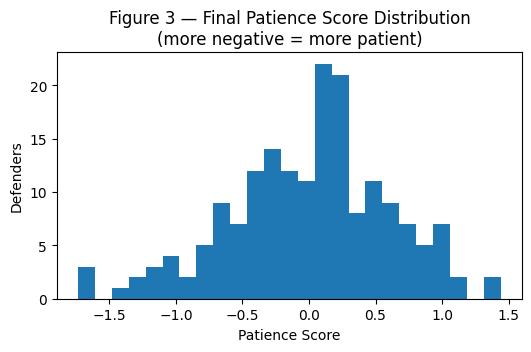

In [26]:
if "player_scores" not in globals():
    print("Figure 3 skipped: player_scores not found.")
elif "patience_score" not in player_scores.columns:
    print("Figure 3 skipped: player_scores missing 'patience_score'.")
else:
    plt.figure(figsize=(6,3.2))
    plt.hist(player_scores["patience_score"].dropna(), bins=25)
    plt.title("Figure 3 — Final Patience Score Distribution\n(more negative = more patient)")
    plt.xlabel("Patience Score")
    plt.ylabel("Defenders")
    plt.show()

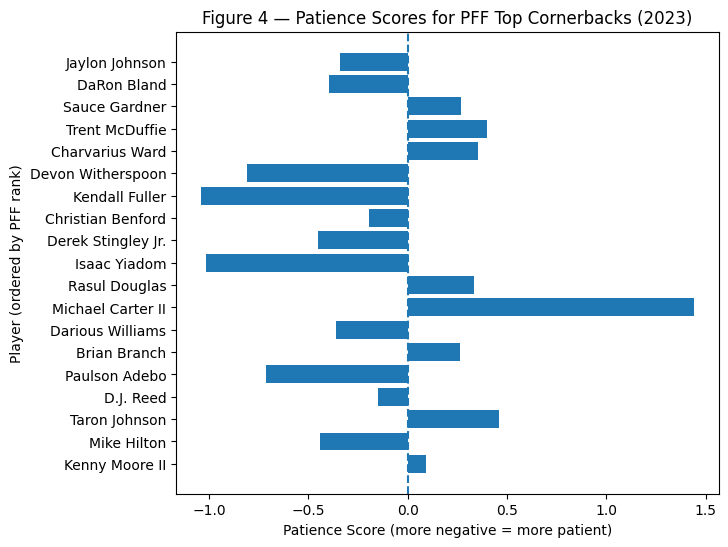

In [27]:
# PFF Top Cornerbacks ordered by 2023 PFF ranking (best to worst)
pff_ranked_names = [
    "Jaylon Johnson",
    "DaRon Bland",
    "Sauce Gardner",
    "Trent McDuffie",
    "Charvarius Ward",
    "Devon Witherspoon",
    "Kendall Fuller",
    "Christian Benford",
    "Derek Stingley Jr.",
    "Isaac Yiadom",
    "Rasul Douglas",
    "Michael Carter II",
    "Darious Williams",
    "Brian Branch",
    "Paulson Adebo",
    "D.J. Reed",
    "Taron Johnson",
    "Mike Hilton",
    "Kenny Moore II"
]

# Check required objects
if "player_scores" not in globals():
    print("Figure 4 skipped: 'player_scores' DataFrame not found.")

elif not all(c in player_scores.columns for c in ["player_name", "patience_score"]):
    print("Figure 4 skipped: missing required columns 'player_name' or 'patience_score'.")

else:
    # Subset to PFF-listed players
    sub = player_scores[player_scores["player_name"].isin(pff_ranked_names)].copy()

    if sub.empty:
        print("Figure 4 skipped: none of the PFF players were found in player_scores.")

    else:
        # Preserve PFF ranking order
        sub["pff_rank_order"] = sub["player_name"].apply(
            lambda x: pff_ranked_names.index(x)
        )
        sub = sub.sort_values("pff_rank_order")

        plt.figure(figsize=(7, 6))
        plt.barh(sub["player_name"], sub["patience_score"])
        plt.axvline(0, linestyle="--")

        plt.title("Figure 4 — Patience Scores for PFF Top Cornerbacks (2023)")
        plt.xlabel("Patience Score (more negative = more patient)")
        plt.ylabel("Player (ordered by PFF rank)")

        plt.gca().invert_yaxis()  # Top-ranked player at top
        plt.show()

## import math
import re

# ------------------------------------------------------
# Helper functions
# ------------------------------------------------------
def ft_in_to_inches(s):
    """Convert strings like '6-02' or '6\'2"' to inches."""
    if pd.isna(s): 
        return None
    s = str(s).strip()
    m = re.search(r"(\d+)\D+(\d+)", s)
    if not m:
        try:
            return float(s)
        except:
            return None
    ft, inch = map(int, m.groups())
    return ft * 12 + inch

def estimate_vertical(row):
    """Estimate vertical jump (in inches) based on position."""
    pos = str(row.get("player_position", "")).upper().strip()
    return DEFAULT_VERTICAL_BY_POS.get(pos, GLOBAL_DEFAULT_VERTICAL)

def calc_catch_radius_in(row):
    """Calculate catch radius in inches using wingspan and vertical."""
    a = row.get("wingspan_est_in")
    b = row.get("vertical_est_in")
    if pd.isna(a) or pd.isna(b):
        return None
    return math.sqrt((a / 2.0) ** 2 + (b ** 2))

# ------------------------------------------------------
# Load your data
# ------------------------------------------------------
sorted_df = pd.read_excel("plays_sorted_by_game.xlsx")

# ------------------------------------------------------
# Calculate catch radius
# ------------------------------------------------------
# 1. Convert height to inches
sorted_df["height_in"] = sorted_df["player_height"].map(ft_in_to_inches)

# 2. Estimate wingspan (Ape Index ~1.02)
DEFAULT_APE_RATIO = 1.02
sorted_df["wingspan_est_in"] = sorted_df["height_in"] * DEFAULT_APE_RATIO

# 3. Estimate verticals by position (excluding irrelevant ones)
DEFAULT_VERTICAL_BY_POS = {
    # Defense
    "CB": 37.0, "S": 36.0, "FS": 36.0, "SS": 36.0, "DB": 37.0,
    "LB": 35.0, "EDGE": 33.0, "DE": 33.0, "DT": 31.0, "DL": 31.0,
    "OT": 29.0, "OG": 29.0, "C": 29.0, "OL": 29.0,
}
GLOBAL_DEFAULT_VERTICAL = 33.0  # Fallback if missing

sorted_df["vertical_est_in"] = sorted_df.apply(estimate_vertical, axis=1)

# 4. Compute catch radius
sorted_df["catch_radius_in"] = sorted_df.apply(calc_catch_radius_in, axis=1)
sorted_df["catch_radius_ft"] = (sorted_df["catch_radius_in"] / 12.0).round(3)

# ------------------------------------------------------
# Create new dataframe to avoid altering the original
# ------------------------------------------------------
plays_with_catch_radius = sorted_df.copy()

# 5. Save simple Excel (no external engine)
output_path = "plays_with_catch_radius.xlsx"
plays_with_catch_radius.to_excel(output_path, index=False)
print(f"Saved: {output_path}  (rows: {len(plays_with_catch_radius)})")
